# Árboles de decisión basados en histogramas

**Nota importante:** estos árboles no están pensados para ser utilizados para predicción, tampoco están realmente optimizados. Su propósito simplemente es el de ilustrar la diferencia en tiempo de entrenamiento cuando se usan histogramas y cuantización vs cuando no.

## Imports

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns

from sklearn.datasets import fetch_california_housing,fetch_openml
from tqdm.notebook import tqdm

sns.set_theme()

## Modelo común

### Búsqueda de threshold para una feature

Mini optimización:

$$
\sum_{i=0}^n (y_i - \bar{y})^2 = \sum_{i=0}^n y_i^2 - n \bar{y}^2 = \sum_{i=0}^n y_i^2 - \frac{1}{n}(\sum_{i=0}^n y_i)^2
$$

Entonces, cuando se agrega una nueva observación se puede computar la nueva pérdida en $\mathcal{O}(1)$.

0  : inf	<-- new min
1  : 988.848	<-- new min
2  : 864.118	<-- new min
3  : 736.792	<-- new min
4  : 600.742	<-- new min
5  : 479.463	<-- new min
6  : 401.749	<-- new min
7  : 374.538	<-- new min
8  : 383.076	
9  : 405.779	
10 : 420.887	
11 : 411.452	
12 : 375.198	
13 : 325.062	<-- new min
14 : 279.732	<-- new min
15 : 263.035	<-- new min
16 : 307.065	
17 : 434.779	
18 : 636.040	
19 : 878.999	


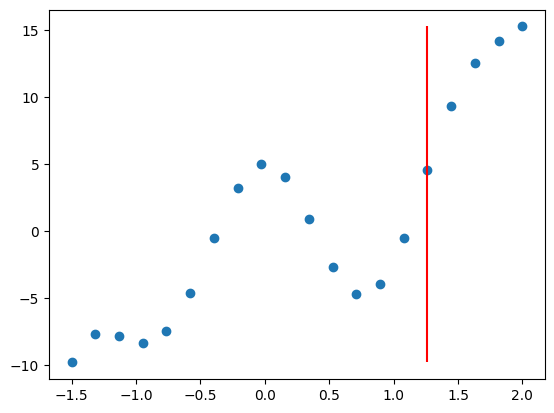

In [4]:
def get_min_threshold_classic(feat_values, target_values, debug=False):
    # init min
    min_idx = None
    min_loss = np.inf

    # sort
    sorted_idxs = np.argsort(feat_values)
    sorted_feat = feat_values[sorted_idxs]
    sorted_targets = target_values[sorted_idxs]

    # init counters
    n = len(feat_values)
    sum_left = 0
    sum_right = sum(target_values)
    sqr_left = 0
    sqr_right = sum(np.square(target_values))

    # search for the min in lin time
    # notar que n_left = idx
    for n_left, tgt in enumerate(sorted_targets):
        # calculate loss
        n_right = n - n_left

        # skip NA
        if n_right * n_left == 0:
            loss = np.inf
        else:
            left_loss = sqr_left - np.square(sum_left) / n_left
            right_loss = sqr_right - np.square(sum_right) / n_right

            loss = n_left/n * left_loss + n_right/n * right_loss

        # if required, update min values
        if loss < min_loss:
            min_idx = n_left
            min_loss = loss

        # debug
        if debug:
            print(f'{n_left: <3}: {loss: >3.3f}\t{"<-- new min" if min_loss == loss else ""}')

        # add this sample to left group
        sum_left += tgt
        sum_right -= tgt

        sqr_left += tgt**2
        sqr_right -= tgt**2

    # return min loss, threshold
    return min_loss, sorted_feat[min_idx]

# show usage
sample_feats = np.linspace(-1.5,2,20)
sample_tgts = -2*sample_feats**2+3*sample_feats**3+5*np.cos(4*sample_feats)

_, x = get_min_threshold_classic(sample_feats, sample_tgts, True)

plt.scatter(sample_feats, sample_tgts)
plt.vlines(x,min(sample_tgts),max(sample_tgts), color='red')
plt.show()

### Árbol

Los árboles necesitan, en general, un criterio de corte. Algunos pueden ser:

* Mínima mejora de loss
* Máxima cantidad de hojas en total
* Mínimo error por nodo
* Máxima profundidad (cantidad de niveles)

Dado que sólo nos interesa mostrar la velocidad, vamos a hacer una simplificación y vamos a establecer un máximo de $k$ niveles.

In [5]:
LEAF_VALUE = -1

class DecisionTree:

    def __init__(self, max_depth):
        self.max_depth = max_depth

    def _build_one(self, X, y, idxs):
        if len(idxs) < len(y):
            X = X[idxs,:]
            y = y[idxs]
        min_loss = np.inf
        min_feat = None
        min_thresh = None
        for feature in range(X.shape[1]):
            loss, thresh = get_min_threshold_classic(X[:,feature],y)
            if loss < min_loss:
                min_loss = loss
                min_feat = feature
                min_thresh = thresh

        mask = X[:,min_feat].flatten() < min_thresh
        idxs_left = idxs[mask]
        idxs_right = idxs[~mask]

        return min_feat, min_thresh, idxs_left, idxs_right

    def fit(self, X, y):

        # init structure
        n_nodes = 2**self.max_depth - 1
        self.thresh_values = np.empty(n_nodes, dtype=float)
        self.thresh_features = np.full(n_nodes, LEAF_VALUE, dtype=int)
        self.preds = np.empty(n_nodes, dtype=float)

        # aux data to prevent copies
        idxs = [None]*n_nodes
        idxs[0] = np.arange(len(y))

        # for each node, build it
        # exploit left_child = 2*parent+1, right_child=2*parent+2
        for node_idx in range(len(self.thresh_values)):

            curr_idxs = idxs[node_idx]
            # save pred for all nodes
            self.preds[node_idx] = y[curr_idxs].mean()

            # if it's a leaf, no point in building split
            left_child_idx = 2*node_idx+1
            if left_child_idx >= n_nodes:
                continue

            # do it in 2 steps for readability
            results = self._build_one(X,y,curr_idxs)

            self.thresh_features[node_idx] = results[0]
            self.thresh_values[node_idx] = results[1]
            idxs[left_child_idx] = results[2]
            idxs[left_child_idx+1] = results[3]

        del idxs

    def predict(self, x):
        idx = 0
        while self.thresh_features[idx] != LEAF_VALUE:
            is_right = x[self.thresh_features[idx]] >= self.thresh_values[idx]
            idx = 2*idx+1+is_right
        return self.preds[idx]

## Modelo con histogramas

**Nota:** vamos a hardcodear un máximo de 256 bins.

### Búsqueda de threshold para una feature

Al igual que en la versión clásica, para cada bin del histograma se necesita: la suma elevada al cuadrado, la suma "lineal" y la cantidad de elementos. Si bien el count debería ser de tipo `uint` y los otros de `float` lo vamos a compilar en una sola matriz de dimensión $ n_{bins} \times 3$ donde las columnas corresponden a `count`, `lin` y `square` en orden.

In [6]:
def get_min_threshold_hist(hist, debug=False):
    # init
    min_loss = np.inf
    min_idx = None

    # init counters
    right = hist.sum(axis=0)

    # here idx != n_left because each idx holds multiple values
    n = right[0]
    left = np.zeros(3, dtype=float)

    for idx, row in enumerate(hist):
        # skip NA
        if left[0] * right[0] == 0:
            loss = np.inf
        else:
            # loss for this split
            # remember split = (count, sum, square)
            left_loss = left[2] - np.square(left[1]) / left[0]
            right_loss = right[2] - np.square(right[1]) / right[0]

            loss = left[0]/n * left_loss + right[0]/n * right_loss

        # if required, update min values
        if loss < min_loss:
            min_idx = idx
            min_loss = loss

        # debug
        if debug:
            # again, we need idx, not n_left (before they were the same)
            print(f'{idx: <3}: {loss: >3.3f}\t{"<-- new min" if min_loss == loss else ""}')

        # move current row to left split
        left += row
        right -= row

    # return min loss, threshold
    return min_loss, min_idx

0  : inf	<-- new min
1  : 988.848	<-- new min
2  : 864.118	<-- new min
3  : 736.792	<-- new min
4  : 600.742	<-- new min
5  : 479.463	<-- new min
6  : 401.749	<-- new min
7  : 374.538	<-- new min
8  : 383.076	
9  : 405.779	
10 : 420.887	
11 : 411.452	
12 : 375.198	
13 : 325.062	<-- new min
14 : 279.732	<-- new min
15 : 263.035	<-- new min
16 : 307.065	
17 : 434.779	
18 : 636.040	
19 : 878.999	


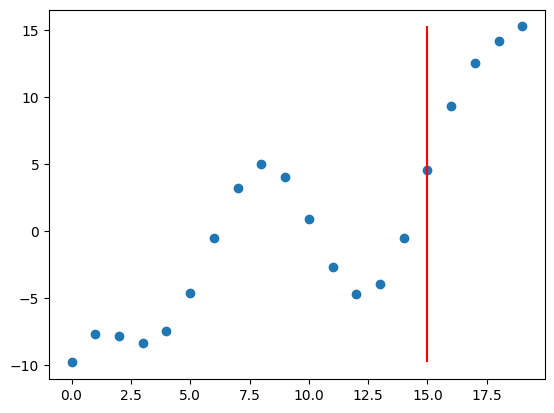

In [7]:
# show usage
# build histograms using previous data, since they're all unique and < 256 it's just argsorting
sample_feats_ordered = np.argsort(sample_feats)
sample_sums = sample_tgts[sample_feats_ordered]
sample_counts = np.ones_like(sample_sums)
sample_squares = sample_sums**2 # only 1 item per bucket -> sum == element

sample_hist = np.column_stack((sample_counts, sample_sums, sample_squares))

_, x2 = get_min_threshold_hist(sample_hist, debug=True)

plt.scatter(sample_feats_ordered, sample_sums)
plt.vlines(x2,min(sample_sums),max(sample_sums), color='red')
plt.show()

### Árbol

In [8]:
asd = np.array([12,3,5,1])
len(asd[asd < 0])

0

In [9]:
def build_hist_by_col(X, y, n_values):
    # build hist by iterating through values of each column
    hists = [np.zeros((bins, 3),dtype=float) for bins in n_values]

    # for each feature
    for i, bins in enumerate(n_values):
        # for each possible value for said feature
        for value in range(bins):
            tgts = y[X[:,i]==value]
            hists[i][value] = [len(tgts), sum(tgts), sum(np.square(tgts))]

    return hists

def build_hist_by_row(X, y, n_values):
    # build hist by iterating throug rows of X
    hists = [np.zeros((bins, 3),dtype=float) for bins in n_values]

    # for each row in X,y
    for X_i, y_i in zip(X, y):
        # for each feature i and its value:
        for i, value in enumerate(X_i):
            hists[i][value] += [1, y_i, y_i**2]

    return hists

In [129]:
LEAF_VALUE = -1

class HistDT:

    def __init__(self, max_depth):
        self.max_depth = max_depth

    def _get_splitting_feat(self, hists):
        min_loss = np.inf
        min_feat = None
        min_thresh = None

        for feature, hist in enumerate(hists):
            loss, thresh = get_min_threshold_hist(hist)
            if loss < min_loss:
                min_loss = loss
                min_feat = feature
                min_thresh = thresh

        return min_loss, min_thresh, min_feat

    def _build_one(self, X, y, idxs, node_hists):
        # determining the split only requires histogram data
        min_loss, min_thresh, min_feat = self._get_splitting_feat(node_hists)

        # this is O(n) though but w/e
        mask = X[idxs,min_feat].flatten() < min_thresh
        idxs_left = idxs[mask]
        idxs_right = idxs[~mask]

        return min_feat, min_thresh, idxs_left, idxs_right

    def fit(self, X, y, by_col = True):

        # assert X matrix is already binned
        assert X.max() < 256

        self.build_hist = build_hist_by_col if by_col else build_hist_by_row

        # init structure
        n_nodes = 2**self.max_depth - 1
        self.thresh_values = np.empty(n_nodes, dtype=float)
        self.thresh_features = np.full(n_nodes, LEAF_VALUE, dtype=int)
        self.preds = np.empty(n_nodes, dtype=float)

        # aux data to prevent copies
        idxs = [None]*n_nodes
        idxs[0] = np.arange(len(y))
        hists = [None]*n_nodes
        max_values = [X[:,i].max()+1 for i in range(X.shape[1])]
        hists[0] = self.build_hist(X,y, max_values)

        # for each node, build it
        # exploit left_child = 2*parent+1, right_child=2*parent+2
        for node_idx in range(len(self.thresh_values)):
            curr_idxs = idxs[node_idx]
            curr_hist = hists[node_idx]

            # save pred for all nodes
            self.preds[node_idx] = y[curr_idxs].mean()

            # if it's a leaf, no point in building split
            left_child_idx = 2*node_idx+1
            if left_child_idx >= n_nodes:
                continue

            # do it in 2 steps for readability
            results = self._build_one(X,y,curr_idxs,curr_hist)

            self.thresh_features[node_idx] = results[0]
            self.thresh_values[node_idx] = results[1]
            idxs[left_child_idx] = results[2]
            idxs[left_child_idx+1] = results[3]

            # build hists for children
            left_child_hists = self.build_hist(X[results[2]],y[results[2]], max_values)
            hists[left_child_idx] = left_child_hists
            hists[left_child_idx+1] = [curr-left_child for curr,left_child in zip(curr_hist, left_child_hists)]

        del idxs
        del hists

    def predict(self, x):
        idx = 0
        while self.thresh_features[idx] != LEAF_VALUE:
            is_right = x[self.thresh_features[idx]] >= self.thresh_values[idx]
            idx = 2*idx+1+is_right
        return self.preds[idx]

## California Housing

In [113]:
full_X, full_y = fetch_california_housing(return_X_y=True)

full_X.shape, full_y.shape

((20640, 8), (20640,))

In [14]:
dfX = pd.DataFrame(full_X)

dfX.agg(lambda x:x.value_counts().values[:5],axis=0) / len(full_X)

,0,1,2,3,4,5,6,7
0,0.002374,0.061676,0.001308,0.013953,0.001211,0.001696,0.011822,0.007849
1,0.002374,0.041764,0.001066,0.001405,0.001163,0.000872,0.011434,0.007752
2,0.002229,0.039922,0.001017,0.001260,0.001163,0.000824,0.011337,0.007171
3,0.002132,0.037355,0.000969,0.001211,0.001163,0.000775,0.011192,0.006977
4,0.002132,0.033818,0.000630,0.001211,0.001163,0.000630,0.010707,0.006880


In [15]:
dfX.nunique(axis=0)

0    12928
1       52
2    19392
3    14233
4     3888
5    18841
6      862
7      844
dtype: int64

Si bien varias de ellas ya están "bineadas" y por lo tanto no va a haber tanta ganancia en reducirlas a 256, podemos observar el funcionamiento igual.

In [114]:
# baseline predictor

((full_y.mean() - full_y)**2).mean()

1.3315503000818076

In [115]:
%%time

dt_classic = DecisionTree(5)
dt_classic.fit(full_X, full_y)

CPU times: user 2.72 s, sys: 8.97 ms, total: 2.73 s
Wall time: 2.76 s


In [116]:
%%time

preds = np.array([dt_classic.predict(x) for x in full_X])

((preds - full_y)**2).mean()

CPU times: user 125 ms, sys: 995 µs, total: 126 ms
Wall time: 127 ms


0.561544218021875

In [117]:
# BINNING
N_BINS = 256
def to_quantiles(array, max_bins):
    unique_values = np.unique(array)
    if len(unique_values) > max_bins:
        unique_values = np.quantile(array, np.linspace(0,1,max_bins))
    return np.digitize(array, unique_values, right=True)

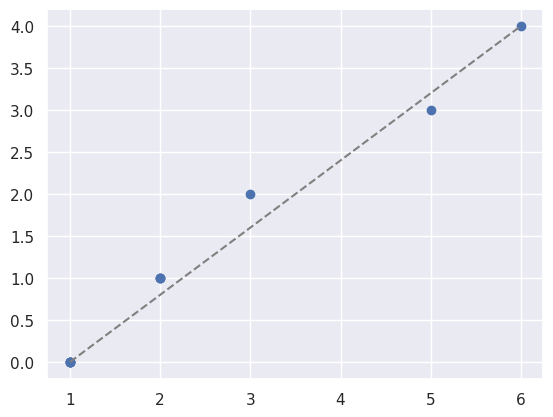

In [118]:
# mostramos uso 1: caso de n_unique <= N_BINS
prev = [1,2,3,1,5,1,2,1,6,1,2]
res = to_quantiles(prev,N_BINS)

plt.scatter(prev, res)
plt.plot((min(prev),max(prev)),(min(res),max(res)), linestyle='dashed', color='gray')
plt.show()

0 255 256


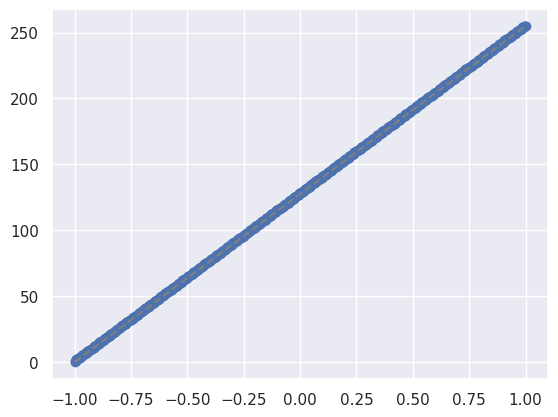

In [119]:
# mostramos uso 2: caso de n_unique > N_BINS
prev = np.linspace(-1,1,1000)
np.random.shuffle(prev)
res = to_quantiles(prev,N_BINS)

print(min(res),max(res), len(np.unique(res)))
plt.scatter(prev, res)
plt.plot((min(prev),max(prev)),(min(res),max(res)), linestyle='dashed', color='gray')
plt.show()

In [120]:
# binneamos X
full_X_binned = np.column_stack([to_quantiles(full_X[:,i], N_BINS) for i in range(full_X.shape[1])]).astype(np.uint8)

pd.DataFrame({'binned':pd.DataFrame(full_X_binned).nunique(), 'original':dfX.nunique(axis=0)})

,binned,original
0,256,12928
1,52,52
2,256,19392
3,254,14233
4,256,3888
5,256,18841
6,210,862
7,235,844


In [121]:
full_X_binned.dtype

dtype('uint8')

In [122]:
full_X.nbytes, full_X_binned.nbytes, round(full_X.nbytes / full_X_binned.nbytes,2)

(1320960, 165120, 8.0)

In [123]:
%%time

dt_classic_binned = DecisionTree(5)
dt_classic_binned.fit(full_X_binned, full_y)

CPU times: user 2.55 s, sys: 7.99 ms, total: 2.55 s
Wall time: 2.57 s


In [124]:
%%time

preds = np.array([dt_classic_binned.predict(x) for x in full_X_binned])

((preds - full_y)**2).mean()

CPU times: user 135 ms, sys: 0 ns, total: 135 ms
Wall time: 138 ms


0.5647070009738583

In [132]:
%%time

dt_hist = HistDT(5)
dt_hist.fit(full_X_binned, full_y)

CPU times: user 665 ms, sys: 3.99 ms, total: 669 ms
Wall time: 674 ms


In [133]:
%%time

preds = np.array([dt_hist.predict(x) for x in full_X_binned])

((preds - full_y)**2).mean()

CPU times: user 135 ms, sys: 2 µs, total: 135 ms
Wall time: 136 ms


0.562320214872016

Ahora probamos con el otro constructor de histogramas

In [134]:
%%time

dt_hist2 = HistDT(5)
dt_hist2.fit(full_X_binned, full_y,False)

CPU times: user 2.47 s, sys: 13.9 ms, total: 2.49 s
Wall time: 2.55 s


In [135]:
%%time

preds = np.array([dt_hist2.predict(x) for x in full_X_binned])

((preds - full_y)**2).mean()

CPU times: user 234 ms, sys: 992 µs, total: 235 ms
Wall time: 252 ms


0.562320214872016

Vemos que efectivamente el constructor por columnas es más rápido.

## Benchmarking

In [95]:
def sample_time(X,y,model_build_f, sample='all', binning=False, rounds=1000, seed=1234):
    # bootstrap
    if sample=='all':
        sample = len(y)
        replace = True
    else:
        assert sample < len(y)
        replace = False

    rng = np.random.default_rng(seed)

    def sample_measure():
        idx_bs = rng.choice(len(y),sample,replace=replace)
        X_bs = X[idx_bs]
        y_bs = y[idx_bs]
        model = model_build_f()
        if binning:
            X_bs = np.column_stack([to_quantiles(X_bs[:,i], N_BINS) for i in range(X_bs.shape[1])])
        elapsed = time.time()
        model.fit(X_bs,y_bs)
        return time.time() - elapsed

    return [sample_measure() for i in tqdm(range(rounds), total=rounds)]

### BNG(cpu_small)

In [88]:
full_X, full_y = fetch_openml(name='BNG(cpu_small)',
                              return_X_y=True, as_frame=False, parser='auto')

full_X.shape, full_y.shape

((1000000, 12), (1000000,))

In [107]:
DEPTH = 7
N_SAMPLES = 100000
ROUNDS = 50
SEED = 1234

In [108]:
res_classic = sample_time(full_X,full_y,lambda: DecisionTree(DEPTH),
                          sample=N_SAMPLES, seed=SEED,
                          rounds=ROUNDS)

  0%|          | 0/50 [00:00<?, ?it/s]

In [109]:
res_classic_binned = sample_time(full_X,full_y,lambda: DecisionTree(DEPTH),
                                 sample=N_SAMPLES, seed=SEED,
                                 binning=True, rounds=ROUNDS)

  0%|          | 0/50 [00:00<?, ?it/s]

In [110]:
res_hist = sample_time(full_X,full_y,lambda: HistDT(DEPTH),
                       sample=N_SAMPLES, seed=SEED,
                       binning=True, rounds=ROUNDS)

  0%|          | 0/50 [00:00<?, ?it/s]

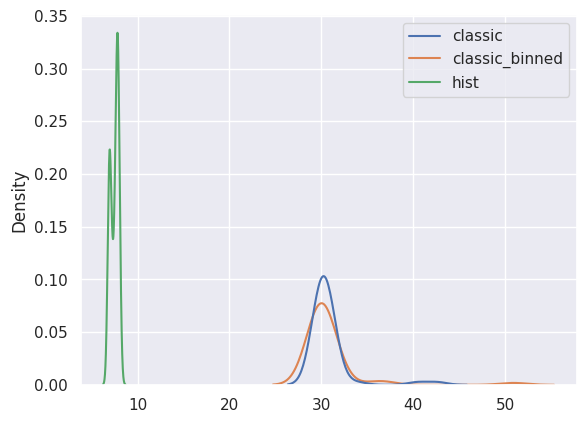

In [111]:
# KDEs

data_concat = res_classic + res_classic_binned + res_hist
labels = ['classic']*len(res_classic) + ['classic_binned']*len(res_classic_binned)+['hist']*len(res_hist)
sns.kdeplot(x=data_concat, hue=labels)
plt.show()

In [112]:
timers_df = pd.DataFrame({
    'classic':res_classic,
    'classic_binned':res_classic_binned,
    'hist': res_hist
})

timers_df['ratio_cls'] = timers_df['classic'] / timers_df['hist']
timers_df['ratio_cls_bin'] = timers_df['classic_binned'] / timers_df['hist']

timers_df.describe().round(3)

,classic,classic_binned,hist,ratio_cls,ratio_cls_bin
count,50.000,50.000,50.000,50.000,50.000
mean,30.787,30.742,7.500,4.120,4.116
std,2.345,3.236,0.417,0.416,0.541
min,29.578,29.179,6.836,3.688,3.631
25%,29.776,29.495,7.006,3.845,3.838
50%,30.218,29.986,7.682,3.996,3.965
75%,30.840,30.679,7.861,4.327,4.290
max,42.630,50.892,8.120,6.020,7.165
